# PyTorch DNN model

In this notebook, we build a deep neural network (DNN) classifier for the CIFAR-10 dataset using PyTorch's `nn.Sequential` module.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Package imports
from image_classification_tools.pytorch.data import make_data_loaders
from image_classification_tools.pytorch.evaluation import evaluate_model
from image_classification_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)

from image_classification_tools.pytorch.training import train_model

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
batch_size = 128
learning_rate = 5e-4
epochs = 150
print_every = 25 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. We convert the images to grayscale for this demonstration.

### 1.1. Load datasets and create DataLoaders

In [3]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load data
train_loader, val_loader, test_loader = make_data_loaders(
    data_dir=data_dir,
    batch_size=batch_size,
    train_transform=transform,
    eval_transform=transform,
    device=device
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 313
Validation batches: 79
Test batches: 79


### 1.2. Visualize sample images

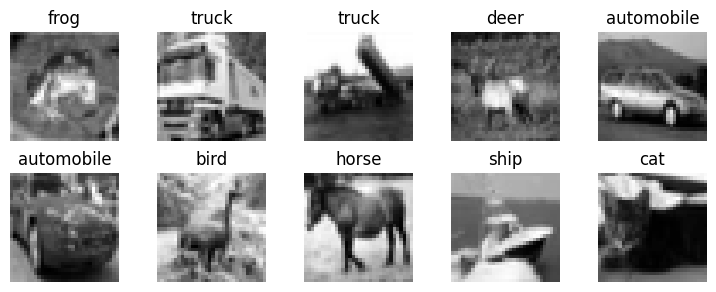

In [4]:
# Get a sample dataset for visualization
sample_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=transform
)

# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(sample_dataset, class_names)
plt.show()

## 2. Build DNN classifier with nn.Sequential

We build a fully connected deep neural network using `nn.Sequential`. Since we are not using convolutional layers, we flatten the 32x32x1 grayscale images into a 1024-dimensional vector.

### 2.1. Define model architecture

In [5]:
# Input size: 1 x 32 x 32 = 1024 (grayscale)
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=1024, out_features=256, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=256, out_features=64, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 1329098


### 2.2. Define loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [7]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)

print()

Epoch 1/150 - loss: 2.1258 - accuracy: 22.64% - val_loss: 1.9553 - val_accuracy: 30.31%
Epoch 25/150 - loss: 1.6884 - accuracy: 40.85% - val_loss: 1.5861 - val_accuracy: 43.48%
Epoch 50/150 - loss: 1.5951 - accuracy: 44.03% - val_loss: 1.5260 - val_accuracy: 45.15%
Epoch 75/150 - loss: 1.5499 - accuracy: 46.07% - val_loss: 1.4915 - val_accuracy: 46.73%
Epoch 100/150 - loss: 1.5041 - accuracy: 47.54% - val_loss: 1.4780 - val_accuracy: 47.09%
Epoch 125/150 - loss: 1.4810 - accuracy: 48.57% - val_loss: 1.4613 - val_accuracy: 48.26%
Epoch 150/150 - loss: 1.4558 - accuracy: 49.60% - val_loss: 1.4571 - val_accuracy: 48.54%

CPU times: user 6min 17s, sys: 1.03 s, total: 6min 18s
Wall time: 6min 11s


### 2.5. Learning curves

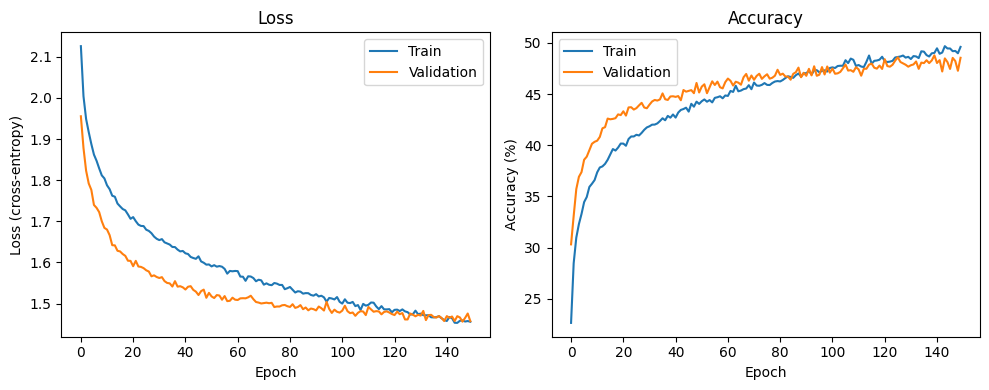

In [8]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [9]:
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 49.02%


### 3.2. Per-class accuracy

In [10]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 48.20%
automobile  : 52.20%
bird        : 41.40%
cat         : 26.20%
deer        : 45.50%
dog         : 44.00%
frog        : 60.20%
horse       : 48.90%
ship        : 68.20%
truck       : 55.40%


### 3.4. Confusion matrix

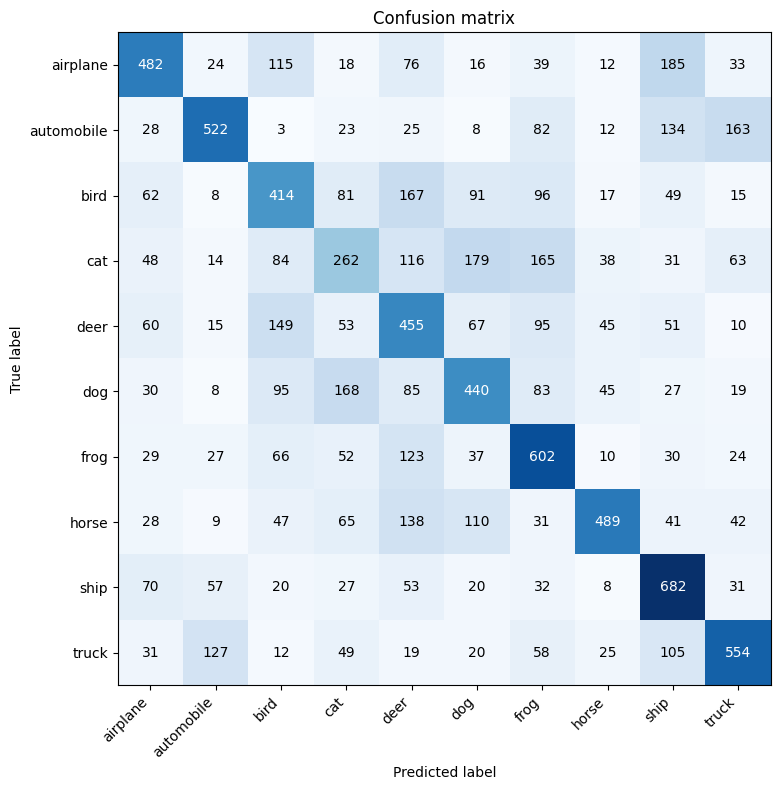

In [11]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.5. Predicted class probability distributions

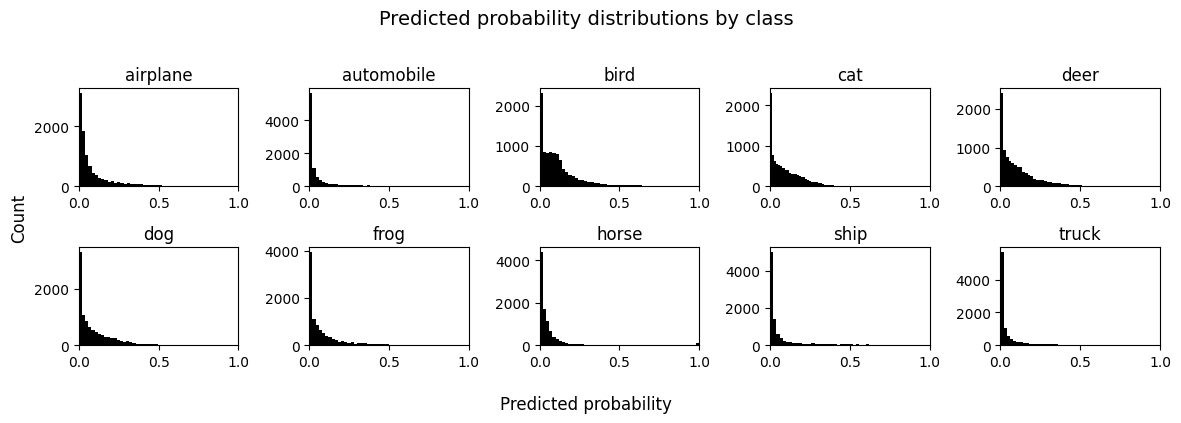

In [12]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.6. Evaluation curves

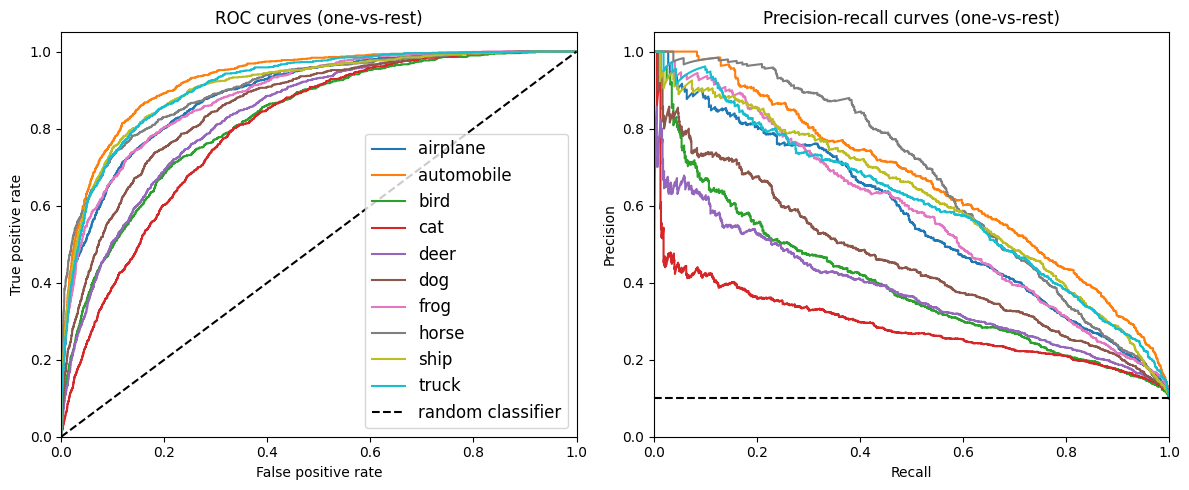

In [13]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [14]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'dnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/dnn.pth
Test accuracy: 49.02%
